We can define the LP as follows. $n$ is the length of the grid, and $s$ is the length of a sub-square within the grid. For instance, if $n = 9$, $s = 3$.

\begin{alignat*}{3}
\sum_{i, j}^{n} x_{ijv} = 1 \\
\sum_{i, v}^{n} x_{ijv} = 1 \\
\sum_{j, v}^{n} x_{ijv} = 1 \\
\sum_{i=si'}^{s(i'+1)} \sum_{j=sj'}^{s(j'+1)} x_{ijv} = 1 \\
i, j, v \in [1, n] \\
i', j' \in [1, s]
\end{alignat*}

In [1]:
import random
import copy
import gurobipy as gp
from gurobipy import GRB, quicksum, max_, abs_
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def create_empty_grid(size=9):
    #0 = "empty"
    return np.zeros((size,size))

In [3]:
def load_test():
    grid = create_empty_grid(9)

    grid[0][1]=2
    grid[0][4]=3
    grid[0][7]=4
    grid[1][0]=6
    grid[1][8]=3
    grid[2][2]=4
    grid[2][6]=5
    grid[3][3]=8
    grid[3][5]=6
    grid[4][0]=8
    grid[4][4]=1
    grid[4][8]=6
    grid[5][3]=7
    grid[5][5]=5
    grid[6][2]=7
    grid[6][6]=6
    grid[7][0]=4
    grid[7][8]=8
    grid[8][1]=3
    grid[8][4]=4
    grid[8][7]=2

    return grid

In [4]:
def print_solution(grid, model, variables):
    print('')
    print('Solution:')
    print('')
    n = len(grid[0])
    s = int(n**0.5)

    # Retrieve optimization result

    solution = model.getAttr('X', variables)

    for i in range(n):
        sol = ''
        if i != 0 and i % s == 0:
            sol += '\n'
        for j in range(n):
            if j != 0 and j % s == 0:
                sol += '  '
            for v in range(n):
                if solution[i, j, v] > 0.5:
                    sol += str(v+1)
        print(sol)

def print_solution2(grid, model, variables, si, sj):
    print('')
    print('Solution:')
    print('')
    n = len(grid[0])

    # Retrieve optimization result

    solution = model.getAttr('X', variables)

    for i in range(n):
        sol = ''
        if i != 0 and i % sj == 0:
            sol += '\n'
        for j in range(n):
            if j != 0 and j % si == 0:
                sol += '  '
            for v in range(n):
                if solution[i, j, v] > 0.5:
                    sol += str(v+1).rjust(n//10 + 2)
        print(sol)

In [5]:
def gurobi_solution(grid):
# In the MIP formulation, binary variables x[i,j,v] indicate whether
# cell <i,j> takes value 'v'.  The constraints are as follows:
#   1. Each cell must take exactly one value (sum_v x[i,j,v] = 1)
#   2. Each value is used exactly once per row (sum_i x[i,j,v] = 1)
#   3. Each value is used exactly once per column (sum_j x[i,j,v] = 1)
#   4. Each value is used exactly once per 3x3 subgrid (sum_grid x[i,j,v] = 1)

    n = len(grid[0])
    s = int(n**0.5)
    model = gp.Model('gurobi')
#     model.Params.LogToConsole = 0
    var = model.addVars(n, n, n, vtype=GRB.BINARY, name='G')


    # Fix variables associated with cells whose values are pre-specified
    for i in range(n):
        for j in range(n):
            if grid[i][j] > 0:
                v = int(grid[i][j]) - 1
                var[i, j, v].LB = 1


    # Each cell must take one value
    model.addConstrs((var.sum(r, c, '*') == 1
                     for r in range(n)
                     for c in range(n)), name='V')


    # Each value appears once per row
    model.addConstrs((var.sum(r, '*', v) == 1
                     for r in range(n)
                     for v in range(n)), name='R')


    # Each value appears once per column
    model.addConstrs((var.sum('*', c, v) == 1
                     for c in range(n)
                     for v in range(n)), name='C')


    # Each value appears once per subgrid
    model.addConstrs((
        gp.quicksum(var[i, j, v] for i in range(i0*s, (i0+1)*s)
                    for j in range(j0*s, (j0+1)*s)) == 1
        for v in range(n)
        for i0 in range(s)
        for j0 in range(s)), name='Sub')

    model.optimize()

    return model, var

In [6]:
def gridtest2():
    grid = np.zeros((12,12))
    grid[1][0] = 2
    grid[1][1] = 12
    grid[1][10] = 7
    grid[2][1] = 3
    grid[3][1] = 5
    grid[4][2] = 4
    grid[5][2] = 9
    grid[7][0] = 6
    grid[8][1] = 8
    grid[8][2] = 2
    grid[8][3] = 5
    grid[9][0] = 12
    grid[9][1] = 4
    grid[9][2] = 7
    grid[10][1] = 10
    grid[11][0] = 1
    grid[11][2] = 5
    
    grid[1][5] = 4
    grid[1][7] = 9
    grid[2][4] = 1
    grid[2][5] = 7
    grid[2][6] = 6
    grid[3][7] = 11
    grid[4][4] = 6
    grid[4][7] = 5
    grid[5][5] = 2
    grid[5][6] = 8
    grid[6][5] = 10
    grid[6][6] = 7
    grid[7][4] = 8
    grid[7][7] = 12
    grid[8][4] = 3
    grid[9][5] = 3
    grid[9][6] = 9
    grid[9][7] = 1
    grid[10][4] = 12
    grid[10][6] = 2
    
    grid[0][9] = 1
    grid[0][11] = 9
    grid[1][10] = 7
    grid[2][9] = 12
    grid[2][10] = 10
    grid[2][11] = 11
    grid[3][8] = 8
    grid[3][9] = 6
    grid[3][10] = 2
    grid[4][11] = 1
    grid[6][9] = 8
    grid[7][9] = 3
    grid[8][10] = 12
    grid[9][10] = 5
    grid[10][10] = 1
    grid[10][11] = 3
    
    return grid

In [7]:
def gurobi_solution2(grid, si, sj, sols=1):
# In the MIP formulation, binary variables x[i,j,v] indicate whether
# cell <i,j> takes value 'v'.  The constraints are as follows:
#   1. Each cell must take exactly one value (sum_v x[i,j,v] = 1)
#   2. Each value is used exactly once per row (sum_i x[i,j,v] = 1)
#   3. Each value is used exactly once per column (sum_j x[i,j,v] = 1)
#   4. Each value is used exactly once per 3x3 subgrid (sum_grid x[i,j,v] = 1)

    n = len(grid[0])
    model = gp.Model('gurobi')
    if sols > 1:
        model.Params.LogToConsole = 0
        model.params.OutputFlag = 0
        model.Params.PoolSolutions = sols
        model.Params.PoolSearchMode = 2
    var = model.addVars(n, n, n, vtype=GRB.BINARY, name='G')


    # Fix variables associated with cells whose values are pre-specified
    for i in range(n):
        for j in range(n):
            if grid[i][j] > 0:
                v = int(grid[i][j]) - 1
                var[i, j, v].LB = 1


    # Each cell must take one value
    model.addConstrs((var.sum(r, c, '*') == 1
                     for r in range(n)
                     for c in range(n)), name='V')


    # Each value appears once per row
    model.addConstrs((var.sum(r, '*', v) == 1
                     for r in range(n)
                     for v in range(n)), name='R')


    # Each value appears once per column
    model.addConstrs((var.sum('*', c, v) == 1
                     for c in range(n)
                     for v in range(n)), name='C')


    # Each value appears once per subgrid
    model.addConstrs((
        gp.quicksum(var[i, j, v] for i in range(i0*sj, (i0+1)*sj)
                    for j in range(j0*si, (j0+1)*si)) == 1
        for v in range(n)
        for i0 in range(si)
        for j0 in range(sj)), name='Sub')

    model.optimize()
    
    solution = np.zeros((n,n))
    sol = model.getAttr('X', var)
    for i in range(n):
        for j in range(n):
            for v in range(n):
                if sol[i, j, v] > 0.5:
                    solution[i][j] = v + 1

    return model, var, solution, model.SolCount

In [8]:

grid = load_test()
mdl, var = gurobi_solution(grid)
print_solution(grid, mdl, var)

Using license file C:\Users\marka\gurobi.lic
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 324 rows, 729 columns and 2916 nonzeros
Model fingerprint: 0xe9ce958b
Variable types: 0 continuous, 729 integer (729 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 324 rows and 729 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%

Solution:

925  631  847
618  574  293
374  982  561

749  826  135
852  413  976
163  795  482

287  359  614
491  267  358
536  148  729


In [9]:
grid = gridtest2()
mdl, var, solution, cnt = gurobi_solution2(grid, 4, 3)
print_solution2(grid, mdl, var, 4, 3)

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 576 rows, 1728 columns and 6912 nonzeros
Model fingerprint: 0x0eadde49
Variable types: 0 continuous, 1728 integer (1728 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 576 rows and 1728 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%

Solution:

 10  7 11  4    5  8 12  3    2  1  6  9
  2 12  1  6   10  4 11  9    3  5  7  8
  5  3  8  9    1  7  6  2    4 12 10 11

  7  5 12 10    9  1  3 11    8  6  2  4
  8 11  4  2    6 12 10  5    9  7  3  1
  3  6  9  1    4  2  8  7   12 10 11  5

 11  1  3 12    2 10  7

In [10]:
def is_used(grid, row, col, num):
    if in_row(grid, row, num):
        return True
    elif in_col(grid, col, num):
        return True
    elif in_mini(grid, row, col, num):
        return True
    return False
    

def in_row(grid, row, num):
    return num in grid[row]


def in_col(grid, col, num):
    size = len(grid[0])
    col_list = [grid[r][col] for r in range(size)]
    return num in col_list


def get_mini_list(grid, row, col):
    size = len(grid[0])
    root = int(size**0.5)
    mini_row = root*(row // root)
    mini_row2 = mini_row + root
    mini_col = root*(col // root)
    mini_col2 = mini_col + root
    mini_list = [grid[r][c] for r in range(mini_row, mini_row2) for c in range(mini_col, mini_col2)]
    return mini_list


def in_mini(grid, row, col, num):
    return num in get_mini_list(grid, row, col)


def has_zeroes(grid):
    size = len(grid[0])
    for row in range(size):
        if 0 in grid[row]:
            return True
    return False

def count_occurances(grid, num=0):
    return sum(cell == num for row in grid for cell in row)

In [11]:
def generate_grid(size=9):
    if(size**0.5 != int(size**0.5)):
        raise ValueError("Size must be a perfect square")
    grid = create_empty_grid(size)
    fill_grid(grid)
    return grid


def fill_grid(grid, solve=False):
    global solver_counter
    size = len(grid[0])
    squared = size**2
    numbers = [temp+1 for temp in range(size)]
    for i in range(0, squared):
        row = i // size
        col = i % size
        if grid[row][col] != 0:
            continue
        if not solve:
            random.shuffle(numbers)
        for num in numbers:
            if not is_used(grid, row, col, num):
                grid[row][col] = num
                if not has_zeroes(grid):
                    solver_counter += 1
                    if solve:
                        break
                    return True
                elif fill_grid(grid, solve):
                    return True
        break
    grid[row][col] = 0


In [12]:
def sparsify(grid, attempts=5):
    # larger number of attempts = the more sparse it gets
    # Warning this could go for awhile!
    global solver_counter
    size = len(grid[0])
    original = copy.deepcopy(grid)
    while attempts > 0:
        row = random.randint(0, size-1)
        col = random.randint(0, size-1)
        while grid[row][col] == 0:
            row = random.randint(0, size-1)
            col = random.randint(0, size-1)
        
        backup = grid[row][col]
        grid[row][col] = 0
        test_grid = copy.deepcopy(grid)

        solver_counter = 0
        fill_grid(test_grid, True)

        if solver_counter != 1:
            grid[row][col] = backup
            attempts -= 1
            print("DECREMENTING ATTEMPTS {} - solver_counter={}".format(attempts, solver_counter))
    return original, grid


def sparsify_no_check(grid, num_clues=None):
    size = len(grid[0])
    clues = num_clues or (size**2 // 4) # just a good speculation
    # 9x9 min = 17     (size**2 // 4 == 20)
    # 16x16 min ?= 51  (size**2 // 4 == 64)
    # 25x25 min ?= 151 (size**2 // 4 == 156)
    original = copy.deepcopy(grid)
    remaining = size**2
    while remaining > clues:
        row = random.randint(0, size-1)
        col = random.randint(0, size-1)
        while grid[row][col] == 0:
            row = random.randint(0, size-1)
            col = random.randint(0, size-1)
        grid[row][col] = 0
        remaining -= 1
    return original, grid

In [13]:
def is_used(grid, si, sj, row, col, num):
    if in_row(grid, row, num):
        return True
    elif in_col(grid, col, num):
        return True
    elif in_mini(grid, si, sj, row, col, num):
        return True
    return False
    

def in_row(grid, row, num):
    return num in grid[row]


def in_col(grid, col, num):
    size = len(grid[0])
    col_list = [grid[r][col] for r in range(size)]
    return num in col_list


def get_mini_list(grid, si, sj, row, col):
    size = len(grid[0])
    root = int(size**0.5)
    mini_row = sj*(row // sj)
    mini_row2 = mini_row + sj
    mini_col = si*(col // si)
    mini_col2 = mini_col + si
    mini_list = [grid[r][c] for r in range(mini_row, mini_row2) for c in range(mini_col, mini_col2)]
    return mini_list


def in_mini(grid, si, sj, row, col, num):
    return num in get_mini_list(grid, si, sj, row, col)


def has_zeroes(grid):
    size = len(grid[0])
    for row in range(size):
        if 0 in grid[row]:
            return True
    return False


def count_occurances(grid, num=0):
    return sum(cell == num for row in grid for cell in row)

In [14]:
global solver_counter
solver_counter = 0

def generate_grid(size=9, si=None, sj=None):
    if(si is None and sj is None):
        if(size**0.5 != int(size**0.5)):
            raise ValueError("Size must be a perfect square, or smaller subgrid dimensions need to be provided")
        si = int(size**0.5)
        sj = int(size**0.5)
    grid = create_empty_grid(size)
    fill_grid(grid, si, sj)
    return grid


def fill_grid(grid, si, sj, solve=False):
    global solver_counter
    size = len(grid[0])
    squared = size**2
    numbers = [temp+1 for temp in range(size)]
    for i in range(0, squared):
        row = i // size
        col = i % size
        if grid[row][col] != 0:
            continue
        if not solve:
            random.shuffle(numbers)
        for num in numbers:
            if not is_used(grid, si, sj, row, col, num):
                grid[row][col] = num
                if not has_zeroes(grid):
                    solver_counter += 1
                    if solve:
                        break
                    return True
                elif fill_grid(grid, si, sj, solve):
                    return True
        break
    grid[row][col] = 0

def sparsify(grid, si, sj, attempts=5):
    # larger number of attempts = the more sparse it gets
    # Warning this could go for awhile!
    global solver_counter
    size = len(grid[0])
    original = copy.deepcopy(grid)
    while attempts > 0:
        row = random.randint(0, size-1)
        col = random.randint(0, size-1)
        while grid[row][col] == 0:
            row = random.randint(0, size-1)
            col = random.randint(0, size-1)
        
        backup = grid[row][col]
        grid[row][col] = 0
        test_grid = copy.deepcopy(grid)

        solver_counter = 0
        fill_grid(test_grid, si, sj, True)

        if solver_counter != 1:
            grid[row][col] = backup
            attempts -= 1
            print("DECREMENTING ATTEMPTS {} - solver_counter={}".format(attempts, solver_counter))
    return original, grid


def sparsify_no_check(grid, si, sj, num_clues=None):
    size = len(grid[0])
    clues = num_clues or (size**2 // 4) # just a good speculation
    # 9x9 min = 17     (size**2 // 4 == 20)
    # 16x16 min ?= 51  (size**2 // 4 == 64)
    # 25x25 min ?= 151 (size**2 // 4 == 156)
    original = copy.deepcopy(grid)
    remaining = size**2
    while remaining > clues:
        row = random.randint(0, size-1)
        col = random.randint(0, size-1)
        while grid[row][col] == 0:
            row = random.randint(0, size-1)
            col = random.randint(0, size-1)
        grid[row][col] = 0
        remaining -= 1
    return original, grid

In [29]:
def sparsify3(g, si, sj, num_clues=0, validate=True):
    original = copy.deepcopy(g)
    grid = copy.deepcopy(g)
    n = len(grid[0])
    remaining = n**2
    clues = num_clues or (n**2 // 4) # just a good speculation
    max_iter = int(n**2.5)
    # 9x9 min = 17     (size**2 // 4 == 20)
    # 12x12 min = 30   (size**2 // 4 == 36)
    # 16x16 min ?= 51  (size**2 // 4 == 64)
    # 25x25 min ?= 151 (size**2 // 4 == 156)
    row = random.randint(1, n) - 1
    col = random.randint(1, n) - 1
    iteration = -1
    stats = []
    while remaining > clues and iteration < max_iter:
        iteration += 1
        x = 0
        while not x:
            row = random.randint(1, n) - 1
            col = random.randint(1, n) - 1
            x = grid[row][col]
        orig_val = grid[row][col]
        grid[row][col] = 0
        remaining -= 1
        if validate:
            m, v, sol, cnt = gurobi_solution2(grid, si, sj, sols=2)
            print(f"iter {str(iteration).rjust(4)}/{max_iter}  grid[{str(row).rjust(2)}][{str(col).rjust(2)}] = {orig_val}  sol_cnt = {cnt}  rem = {remaining}  soltime = {m.Runtime}")
            stats.append({
                "clues": clues,
                "max_iter": max_iter,
                "iter": iteration,
                "remaining": remaining,
                "row": row,
                "col": col,
                "orig_val": orig_val,
                "sol_cnt": cnt,
                "runtime": m.Runtime
            })
            if cnt != 1: # 0 = not solvable, 2 = too many
                grid[row][col] = orig_val
                remaining += 1
    return original, grid, stats

In [30]:

test = np.zeros((12,12))
fill_grid(test, 4, 3)
original = copy.deepcopy(test)
grid = copy.deepcopy(original)
o, g, stats = sparsify3(grid, 4, 3)

iter    0/498  grid[ 7][ 0] = 2.0  val = 1  rem = 143  soltime = 0.0039997100830078125
iter    1/498  grid[ 6][ 7] = 11.0  val = 1  rem = 142  soltime = 0.0030002593994140625
iter    2/498  grid[ 3][ 4] = 6.0  val = 1  rem = 141  soltime = 0.0029850006103515625
iter    3/498  grid[10][ 5] = 1.0  val = 1  rem = 140  soltime = 0.002010345458984375
iter    4/498  grid[ 7][ 9] = 12.0  val = 1  rem = 139  soltime = 0.0010013580322265625
iter    5/498  grid[ 2][11] = 11.0  val = 1  rem = 138  soltime = 0.0020008087158203125
iter    6/498  grid[ 4][ 7] = 9.0  val = 1  rem = 137  soltime = 0.00098419189453125
iter    7/498  grid[ 8][10] = 3.0  val = 1  rem = 136  soltime = 0.0050029754638671875
iter    8/498  grid[ 6][ 8] = 2.0  val = 1  rem = 135  soltime = 0.0009860992431640625
iter    9/498  grid[ 2][ 5] = 4.0  val = 1  rem = 134  soltime = 0.0030059814453125
iter   10/498  grid[ 9][ 6] = 3.0  val = 1  rem = 133  soltime = 0.0019989013671875
iter   11/498  grid[ 2][ 8] = 12.0  val = 1  rem 

iter   97/498  grid[ 9][ 4] = 9.0  val = 1  rem = 56  soltime = 0.0030002593994140625
iter   98/498  grid[10][ 9] = 2.0  val = 2  rem = 55  soltime = 0.009000778198242188
iter   99/498  grid[ 3][ 5] = 2.0  val = 1  rem = 55  soltime = 0.0039997100830078125
iter  100/498  grid[ 4][ 4] = 5.0  val = 1  rem = 54  soltime = 0.004001617431640625
iter  101/498  grid[ 6][ 0] = 3.0  val = 1  rem = 53  soltime = 0.0030002593994140625
iter  102/498  grid[ 3][ 7] = 3.0  val = 1  rem = 52  soltime = 0.0070018768310546875
iter  103/498  grid[ 0][ 1] = 4.0  val = 2  rem = 51  soltime = 0.01399993896484375
iter  104/498  grid[10][11] = 9.0  val = 2  rem = 51  soltime = 0.03901100158691406
iter  105/498  grid[10][ 2] = 6.0  val = 2  rem = 51  soltime = 0.02701568603515625
iter  106/498  grid[ 5][ 2] = 9.0  val = 2  rem = 51  soltime = 0.015001296997070312
iter  107/498  grid[ 2][ 0] = 1.0  val = 2  rem = 51  soltime = 0.022003173828125
iter  108/498  grid[ 7][ 5] = 3.0  val = 2  rem = 51  soltime = 0.0

iter  194/498  grid[10][ 0] = 5.0  val = 2  rem = 47  soltime = 0.03199958801269531
iter  195/498  grid[ 0][ 5] = 9.0  val = 2  rem = 47  soltime = 0.027002334594726562
iter  196/498  grid[ 7][ 3] = 10.0  val = 2  rem = 47  soltime = 0.05100250244140625
iter  197/498  grid[ 0][ 6] = 6.0  val = 2  rem = 47  soltime = 0.028005599975585938
iter  198/498  grid[ 7][ 3] = 10.0  val = 2  rem = 47  soltime = 0.043003082275390625
iter  199/498  grid[ 8][ 2] = 7.0  val = 2  rem = 47  soltime = 0.025005340576171875
iter  200/498  grid[ 8][ 7] = 4.0  val = 2  rem = 47  soltime = 0.02300262451171875
iter  201/498  grid[ 1][ 9] = 4.0  val = 2  rem = 47  soltime = 0.03201103210449219
iter  202/498  grid[ 0][11] = 2.0  val = 2  rem = 47  soltime = 0.029996871948242188
iter  203/498  grid[ 2][ 7] = 2.0  val = 2  rem = 47  soltime = 0.032001495361328125
iter  204/498  grid[ 7][ 7] = 6.0  val = 2  rem = 47  soltime = 0.032001495361328125
iter  205/498  grid[ 0][ 7] = 8.0  val = 2  rem = 47  soltime = 0.0

iter  292/498  grid[ 4][10] = 2.0  val = 2  rem = 47  soltime = 0.02301788330078125
iter  293/498  grid[ 9][ 2] = 11.0  val = 2  rem = 47  soltime = 0.04300689697265625
iter  294/498  grid[ 6][ 3] = 4.0  val = 2  rem = 47  soltime = 0.024013519287109375
iter  295/498  grid[ 0][11] = 2.0  val = 2  rem = 47  soltime = 0.022001266479492188
iter  296/498  grid[10][ 9] = 2.0  val = 2  rem = 47  soltime = 0.022001266479492188
iter  297/498  grid[ 0][ 7] = 8.0  val = 2  rem = 47  soltime = 0.031003952026367188
iter  298/498  grid[10][ 2] = 6.0  val = 2  rem = 47  soltime = 0.02300262451171875
iter  299/498  grid[ 9][ 7] = 10.0  val = 2  rem = 47  soltime = 0.019001007080078125
iter  300/498  grid[ 3][ 9] = 9.0  val = 2  rem = 47  soltime = 0.03300285339355469
iter  301/498  grid[ 6][ 9] = 8.0  val = 2  rem = 47  soltime = 0.0330047607421875
iter  302/498  grid[10][ 2] = 6.0  val = 2  rem = 47  soltime = 0.04698371887207031
iter  303/498  grid[11][ 4] = 11.0  val = 2  rem = 47  soltime = 0.027

iter  391/498  grid[10][ 6] = 12.0  val = 2  rem = 47  soltime = 0.03300285339355469
iter  392/498  grid[ 3][ 9] = 9.0  val = 2  rem = 47  soltime = 0.025014877319335938
iter  393/498  grid[ 1][ 9] = 4.0  val = 2  rem = 47  soltime = 0.02300262451171875
iter  394/498  grid[10][ 0] = 5.0  val = 2  rem = 47  soltime = 0.023019790649414062
iter  395/498  grid[10][ 1] = 8.0  val = 2  rem = 47  soltime = 0.03200340270996094
iter  396/498  grid[ 0][ 9] = 7.0  val = 2  rem = 47  soltime = 0.08100700378417969
iter  397/498  grid[ 7][ 5] = 3.0  val = 2  rem = 47  soltime = 0.029998779296875
iter  398/498  grid[ 6][ 6] = 10.0  val = 2  rem = 47  soltime = 0.03199958801269531
iter  399/498  grid[ 5][ 2] = 9.0  val = 2  rem = 47  soltime = 0.022003173828125
iter  400/498  grid[ 9][ 3] = 2.0  val = 2  rem = 47  soltime = 0.028001785278320312
iter  401/498  grid[ 7][ 5] = 3.0  val = 2  rem = 47  soltime = 0.0260009765625
iter  402/498  grid[ 6][ 6] = 10.0  val = 2  rem = 47  soltime = 0.032003402709

iter  488/498  grid[ 5][11] = 3.0  val = 2  rem = 47  soltime = 0.0260009765625
iter  489/498  grid[ 4][ 1] = 11.0  val = 2  rem = 47  soltime = 0.0240020751953125
iter  490/498  grid[ 0][ 5] = 9.0  val = 2  rem = 47  soltime = 0.027984619140625
iter  491/498  grid[ 4][10] = 2.0  val = 2  rem = 47  soltime = 0.019001007080078125
iter  492/498  grid[ 8][11] = 1.0  val = 2  rem = 47  soltime = 0.03598785400390625
iter  493/498  grid[ 0][ 9] = 7.0  val = 2  rem = 47  soltime = 0.04100227355957031
iter  494/498  grid[ 8][ 7] = 4.0  val = 2  rem = 47  soltime = 0.02301788330078125
iter  495/498  grid[ 9][ 3] = 2.0  val = 2  rem = 47  soltime = 0.027990341186523438
iter  496/498  grid[ 4][10] = 2.0  val = 2  rem = 47  soltime = 0.025030136108398438
iter  497/498  grid[ 0][ 6] = 6.0  val = 2  rem = 47  soltime = 0.021001815795898438
iter  498/498  grid[ 4][10] = 2.0  val = 2  rem = 47  soltime = 0.019001007080078125


In [18]:
o

array([[ 4.,  1.,  3.,  7.,  5.,  9., 12.,  2.,  6., 10., 11.,  8.],
       [ 6.,  8., 12., 10., 11.,  1.,  3.,  4.,  2.,  7.,  5.,  9.],
       [ 2.,  5., 11.,  9.,  6., 10.,  8.,  7.,  3., 12.,  1.,  4.],
       [ 1., 11.,  2.,  5.,  7.,  3.,  4.,  9.,  8.,  6., 10., 12.],
       [ 9.,  7.,  8.,  3.,  2., 12., 10.,  6., 11.,  5.,  4.,  1.],
       [12.,  4., 10.,  6.,  8., 11.,  5.,  1.,  9.,  2.,  7.,  3.],
       [ 8.,  3.,  6.,  1., 12.,  2., 11., 10.,  7.,  4.,  9.,  5.],
       [ 5.,  9.,  4., 12.,  3.,  7.,  6.,  8.,  1., 11.,  2., 10.],
       [11., 10.,  7.,  2.,  1.,  4.,  9.,  5., 12.,  3.,  8.,  6.],
       [ 3.,  2.,  9.,  4., 10.,  8.,  7., 12.,  5.,  1.,  6., 11.],
       [10.,  6.,  1., 11.,  9.,  5.,  2.,  3.,  4.,  8., 12.,  7.],
       [ 7., 12.,  5.,  8.,  4.,  6.,  1., 11., 10.,  9.,  3.,  2.]])

In [19]:
g

array([[ 0.,  0.,  3.,  0.,  5.,  0.,  0.,  0.,  0., 10., 11.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  3.,  4.,  0.,  0.,  0.,  9.],
       [ 2.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0., 12.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  3.,  4.,  0.,  0.,  0., 10., 12.],
       [ 0.,  0.,  8.,  0.,  0., 12., 10.,  0.,  0.,  0.,  4.,  0.],
       [12.,  0.,  0.,  6.,  8.,  0.,  0.,  0.,  9.,  0.,  0.,  0.],
       [ 8.,  0.,  0.,  1., 12.,  2.,  0.,  0.,  0.,  4.,  0.,  0.],
       [ 0.,  9.,  4.,  0.,  0.,  7.,  0.,  0.,  1., 11.,  0.,  0.],
       [ 0.,  0.,  7.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  8.,  0.],
       [ 0.,  2.,  9.,  4.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.],
       [ 0.,  0.,  1., 11.,  0.,  5.,  2.,  0.,  0.,  0.,  0.,  7.],
       [ 0.,  0.,  5.,  0.,  4.,  0.,  0.,  0.,  0.,  9.,  0.,  0.]])

In [32]:
df = pd.DataFrame(stats)

In [36]:
df.describe()

,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime
count,499.0,499.0,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,36.0,498.0,249.000000,57.096192,5.490982,5.607214,6.408818,1.807615,0.022478
std,0.0,0.0,144.193157,22.678183,3.406440,3.470187,3.255703,0.394569,0.013227
min,36.0,498.0,0.000000,47.000000,0.000000,0.000000,1.000000,1.000000,0.000984
25%,36.0,498.0,124.500000,47.000000,3.000000,2.000000,4.000000,2.000000,0.016001
50%,36.0,498.0,249.000000,47.000000,6.000000,6.000000,7.000000,2.000000,0.023006
75%,36.0,498.0,373.500000,49.500000,9.000000,9.000000,9.000000,2.000000,0.030003
max,36.0,498.0,498.000000,143.000000,11.000000,11.000000,12.000000,2.000000,0.081007


In [42]:
df.columns

Index(['clues', 'max_iter', 'iter', 'remaining', 'row', 'col', 'orig_val',
       'sol_cnt', 'runtime'],
      dtype='object')

In [43]:
df[['remaining', 'runtime']].groupby('remaining').describe()

runtime                                                              \
            count      mean       std       min       25%       50%       75%   
remaining                                                                       
47          325.0  0.028164  0.009981  0.009001  0.021992  0.026001  0.032007   
48            2.0  0.012001  0.007073  0.007000  0.009501  0.012001  0.014502   
49           47.0  0.026259  0.008775  0.007000  0.020004  0.026001  0.030503   
50           13.0  0.021929  0.008551  0.009001  0.015005  0.023005  0.026012   
51            9.0  0.020227  0.009288  0.009001  0.014000  0.017010  0.026003   
...           ...       ...       ...       ...       ...       ...       ...   
139           1.0  0.001001       NaN  0.001001  0.001001  0.001001  0.001001   
140           1.0  0.002010       NaN  0.002010  0.002010  0.002010  0.002010   
141           1.0  0.002985       NaN  0.002985  0.002985  0.002985  0.002985   
142           1.0  0.003000       NaN  0.003000  0.003000  0.003000  0.003000   
143           1.0  0.004000       NaN  0.004000  0.004000  0.004000  0.004000   

                     
                max  
remaining            
47         0.081007  
48         0.017002  
49         0.049004  
50         0.037003  
51         0.039011  
...             ...  
139        0.001001  
140        0.002010  
141        0.002985  
142        0.003000  
143        0.004000  

[97 rows x 8 columns]

In [44]:
df[['sol_cnt']].describe()

,sol_cnt
count,499.000000
mean,1.807615
std,0.394569
min,1.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,2.000000


In [47]:
df2 = df[['remaining', 'runtime']].groupby('remaining')

In [50]:
df2.describe()

runtime                                                              \
            count      mean       std       min       25%       50%       75%   
remaining                                                                       
47          325.0  0.028164  0.009981  0.009001  0.021992  0.026001  0.032007   
48            2.0  0.012001  0.007073  0.007000  0.009501  0.012001  0.014502   
49           47.0  0.026259  0.008775  0.007000  0.020004  0.026001  0.030503   
50           13.0  0.021929  0.008551  0.009001  0.015005  0.023005  0.026012   
51            9.0  0.020227  0.009288  0.009001  0.014000  0.017010  0.026003   
...           ...       ...       ...       ...       ...       ...       ...   
139           1.0  0.001001       NaN  0.001001  0.001001  0.001001  0.001001   
140           1.0  0.002010       NaN  0.002010  0.002010  0.002010  0.002010   
141           1.0  0.002985       NaN  0.002985  0.002985  0.002985  0.002985   
142           1.0  0.003000       NaN  0.003000  0.003000  0.003000  0.003000   
143           1.0  0.004000       NaN  0.004000  0.004000  0.004000  0.004000   

                     
                max  
remaining            
47         0.081007  
48         0.017002  
49         0.049004  
50         0.037003  
51         0.039011  
...             ...  
139        0.001001  
140        0.002010  
141        0.002985  
142        0.003000  
143        0.004000  

[97 rows x 8 columns]

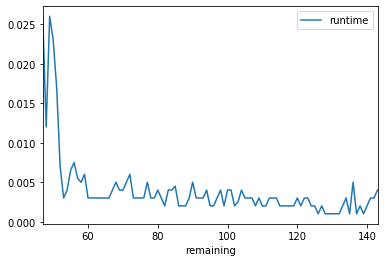

In [86]:
df2.median().plot(kind='line')

In [90]:
df2.describe()

runtime                                                              \
            count      mean       std       min       25%       50%       75%   
remaining                                                                       
47          325.0  0.028164  0.009981  0.009001  0.021992  0.026001  0.032007   
48            2.0  0.012001  0.007073  0.007000  0.009501  0.012001  0.014502   
49           47.0  0.026259  0.008775  0.007000  0.020004  0.026001  0.030503   
50           13.0  0.021929  0.008551  0.009001  0.015005  0.023005  0.026012   
51            9.0  0.020227  0.009288  0.009001  0.014000  0.017010  0.026003   
...           ...       ...       ...       ...       ...       ...       ...   
139           1.0  0.001001       NaN  0.001001  0.001001  0.001001  0.001001   
140           1.0  0.002010       NaN  0.002010  0.002010  0.002010  0.002010   
141           1.0  0.002985       NaN  0.002985  0.002985  0.002985  0.002985   
142           1.0  0.003000       NaN  0.003000  0.003000  0.003000  0.003000   
143           1.0  0.004000       NaN  0.004000  0.004000  0.004000  0.004000   

                     
                max  
remaining            
47         0.081007  
48         0.017002  
49         0.049004  
50         0.037003  
51         0.039011  
...             ...  
139        0.001001  
140        0.002010  
141        0.002985  
142        0.003000  
143        0.004000  

[97 rows x 8 columns]

In [121]:
tests = [
    {
        "size":8,
        "si":4,
        "sj":2,
        "clues":0
    },
    {
        "size":9,
        "si":3,
        "sj":3,
        "clues":0
    },
    {
        "size":10,
        "si":5,
        "sj":2,
        "clues":0
    },
    {
        "size":12,
        "si":4,
        "sj":3,
        "clues":0
    },
    {
        "size":12,
        "si":6,
        "sj":2,
        "clues":0
    },
    {
        "size":16,
        "si":4,
        "sj":4,
        "clues":0
    },
    {
        "size":16,
        "si":8,
        "sj":2,
        "clues":0
    },
    {
        "size":20,
        "si":5,
        "sj":4,
        "clues":0
    },
    {
        "size":20,
        "si":5,
        "sj":4,
        "clues":0
    },
    {
        "size":20,
        "si":10,
        "sj":2,
        "clues":0
    },
    {
        "size":24,
        "si":6,
        "sj":4,
        "clues":0
    },
    {
        "size":24,
        "si":8,
        "sj":3,
        "clues":0
    },
    {
        "size":24,
        "si":12,
        "sj":2,
        "clues":0
    },
    {
        "size":25,
        "si":5,
        "sj":5,
        "clues":0
    }
]

In [ ]:
tests2 = [
    {
        "size":20,
        "si":10,
        "sj":2,
        "clues":0
    },
    {
        "size":24,
        "si":6,
        "sj":4,
        "clues":0
    },
    {
        "size":24,
        "si":8,
        "sj":3,
        "clues":0
    },
    {
        "size":24,
        "si":12,
        "sj":2,
        "clues":0
    },
    {
        "size":25,
        "si":5,
        "sj":5,
        "clues":0
    }
]

In [116]:
import time
def run(size, si, sj, clues, iterations=10):
    results = []
    clue_goal = clues or (size**2 // 4) # same formula as sparsify3()
    overall_start = time.time()
    for i in range(iterations):
        print("\n\n\n------------  TEST {}/{}   SIZE={} ({}x{})   CLUE GOAL={}  ------------".format(
                i+1, iterations, size, si, sj, clue_goal))
        itestgrid = np.zeros((size, size))
        filling_start = time.time()
        fill_grid(itestgrid, si, sj)
        filling = time.time() - filling_start
        sparsing_start = time.time()
        o, g, stat = sparsify3(itestgrid, si, sj, clues)
        sparsing = time.time() - sparsing_start
        results.append({
            'grid': o,
            'sparsed': g,
            'stats': stat,
            'clue_goal': clue_goal,
            'clue_count': size**2 - count_occurances(g, 0),
            'timings': {
                'filling': filling,
                'sparsing': sparsing,
                'overall': time.time() - overall_start
            }
        })
    overall_time = time.time() - overall_start
    print("\n\nDONE ({})\n\n".format(overall_time))    
    return results, overall_time

In [111]:
# results, overall_time = run(**tests[0], iterations=10)




------------  TEST 1/10   SIZE=8 (4x2)   CLUES(attempted)=0  ------------
iter    0/181  grid[ 6][ 4] = 2.0  val = 1  rem = 63  soltime = 0.00099945068359375
iter    1/181  grid[ 0][ 4] = 3.0  val = 1  rem = 62  soltime = 0.0010013580322265625
iter    2/181  grid[ 1][ 6] = 2.0  val = 1  rem = 61  soltime = 0.00099945068359375
iter    3/181  grid[ 7][ 2] = 2.0  val = 1  rem = 60  soltime = 0.00099945068359375
iter    4/181  grid[ 0][ 2] = 1.0  val = 1  rem = 59  soltime = 0.0
iter    5/181  grid[ 0][ 0] = 8.0  val = 1  rem = 58  soltime = 0.00099945068359375
iter    6/181  grid[ 5][ 6] = 1.0  val = 1  rem = 57  soltime = 0.0010013580322265625
iter    7/181  grid[ 5][ 1] = 8.0  val = 1  rem = 56  soltime = 0.001003265380859375
iter    8/181  grid[ 7][ 5] = 5.0  val = 1  rem = 55  soltime = 0.0010013580322265625
iter    9/181  grid[ 1][ 0] = 6.0  val = 1  rem = 54  soltime = 0.00099945068359375
iter   10/181  grid[ 2][ 1] = 6.0  val = 1  rem = 53  soltime = 0.0010013580322265625
iter  

iter  102/181  grid[ 1][ 7] = 1.0  val = 2  rem = 19  soltime = 0.01200103759765625
iter  103/181  grid[ 3][ 1] = 2.0  val = 2  rem = 19  soltime = 0.004001617431640625
iter  104/181  grid[ 0][ 3] = 2.0  val = 2  rem = 19  soltime = 0.0110015869140625
iter  105/181  grid[ 3][ 0] = 1.0  val = 2  rem = 19  soltime = 0.0059986114501953125
iter  106/181  grid[ 0][ 5] = 6.0  val = 2  rem = 19  soltime = 0.007999420166015625
iter  107/181  grid[ 3][ 4] = 6.0  val = 2  rem = 19  soltime = 0.01200103759765625
iter  108/181  grid[ 0][ 6] = 7.0  val = 2  rem = 19  soltime = 0.008998870849609375
iter  109/181  grid[ 7][ 4] = 8.0  val = 2  rem = 19  soltime = 0.011016845703125
iter  110/181  grid[ 4][ 3] = 3.0  val = 2  rem = 19  soltime = 0.010995864868164062
iter  111/181  grid[ 0][ 3] = 2.0  val = 2  rem = 19  soltime = 0.010000228881835938
iter  112/181  grid[ 0][ 3] = 2.0  val = 2  rem = 19  soltime = 0.009000778198242188
iter  113/181  grid[ 2][ 0] = 3.0  val = 2  rem = 19  soltime = 0.00800

iter   16/181  grid[ 7][ 5] = 6.0  val = 1  rem = 47  soltime = 0.0010013580322265625
iter   17/181  grid[ 6][ 6] = 1.0  val = 1  rem = 46  soltime = 0.00099945068359375
iter   18/181  grid[ 3][ 4] = 5.0  val = 1  rem = 45  soltime = 0.00099945068359375
iter   19/181  grid[ 5][ 7] = 6.0  val = 1  rem = 44  soltime = 0.00099945068359375
iter   20/181  grid[ 3][ 2] = 6.0  val = 1  rem = 43  soltime = 0.0020084381103515625
iter   21/181  grid[ 6][ 3] = 4.0  val = 1  rem = 42  soltime = 0.0010013580322265625
iter   22/181  grid[ 2][ 5] = 1.0  val = 1  rem = 41  soltime = 0.00099945068359375
iter   23/181  grid[ 1][ 0] = 4.0  val = 1  rem = 40  soltime = 0.0020008087158203125
iter   24/181  grid[ 1][ 7] = 2.0  val = 1  rem = 39  soltime = 0.00099945068359375
iter   25/181  grid[ 1][ 6] = 6.0  val = 1  rem = 38  soltime = 0.0030040740966796875
iter   26/181  grid[ 0][ 7] = 1.0  val = 1  rem = 37  soltime = 0.00299835205078125
iter   27/181  grid[ 0][ 5] = 4.0  val = 1  rem = 36  soltime = 0.

iter  115/181  grid[ 3][ 3] = 7.0  val = 2  rem = 18  soltime = 0.0020008087158203125
iter  116/181  grid[ 1][ 5] = 5.0  val = 2  rem = 18  soltime = 0.006000518798828125
iter  117/181  grid[ 5][ 1] = 4.0  val = 2  rem = 18  soltime = 0.00800323486328125
iter  118/181  grid[ 1][ 4] = 7.0  val = 2  rem = 18  soltime = 0.006000518798828125
iter  119/181  grid[ 7][ 7] = 5.0  val = 2  rem = 18  soltime = 0.010999679565429688
iter  120/181  grid[ 1][ 5] = 5.0  val = 2  rem = 18  soltime = 0.0049991607666015625
iter  121/181  grid[ 0][ 3] = 5.0  val = 2  rem = 18  soltime = 0.012002944946289062
iter  122/181  grid[ 3][ 1] = 1.0  val = 2  rem = 18  soltime = 0.010982513427734375
iter  123/181  grid[ 1][ 4] = 7.0  val = 2  rem = 18  soltime = 0.002994537353515625
iter  124/181  grid[ 2][ 4] = 6.0  val = 2  rem = 18  soltime = 0.013986587524414062
iter  125/181  grid[ 6][ 1] = 6.0  val = 2  rem = 18  soltime = 0.008998870849609375
iter  126/181  grid[ 2][ 4] = 6.0  val = 2  rem = 18  soltime = 

iter   31/181  grid[ 3][ 4] = 3.0  val = 1  rem = 33  soltime = 0.0019989013671875
iter   32/181  grid[ 7][ 5] = 2.0  val = 2  rem = 32  soltime = 0.0039997100830078125
iter   33/181  grid[ 3][ 3] = 6.0  val = 1  rem = 32  soltime = 0.0019989013671875
iter   34/181  grid[ 6][ 1] = 2.0  val = 1  rem = 31  soltime = 0.0020008087158203125
iter   35/181  grid[ 6][ 6] = 6.0  val = 1  rem = 30  soltime = 0.0020008087158203125
iter   36/181  grid[ 2][ 0] = 8.0  val = 1  rem = 29  soltime = 0.002002716064453125
iter   37/181  grid[ 7][ 0] = 6.0  val = 1  rem = 28  soltime = 0.0019989013671875
iter   38/181  grid[ 3][ 7] = 7.0  val = 1  rem = 27  soltime = 0.002017974853515625
iter   39/181  grid[ 2][ 1] = 7.0  val = 1  rem = 26  soltime = 0.00299835205078125
iter   40/181  grid[ 5][ 3] = 8.0  val = 2  rem = 25  soltime = 0.0030002593994140625
iter   41/181  grid[ 2][ 6] = 1.0  val = 2  rem = 25  soltime = 0.0050182342529296875
iter   42/181  grid[ 7][ 5] = 2.0  val = 2  rem = 25  soltime = 0.0

iter  128/181  grid[ 5][ 4] = 6.0  val = 2  rem = 19  soltime = 0.0039997100830078125
iter  129/181  grid[ 2][ 6] = 1.0  val = 2  rem = 19  soltime = 0.0049991607666015625
iter  130/181  grid[ 5][ 4] = 6.0  val = 2  rem = 19  soltime = 0.003017425537109375
iter  131/181  grid[ 5][ 4] = 6.0  val = 2  rem = 19  soltime = 0.0030002593994140625
iter  132/181  grid[ 2][ 2] = 3.0  val = 2  rem = 19  soltime = 0.006999969482421875
iter  133/181  grid[ 2][ 6] = 1.0  val = 2  rem = 19  soltime = 0.005001068115234375
iter  134/181  grid[ 5][ 3] = 8.0  val = 2  rem = 19  soltime = 0.0049991607666015625
iter  135/181  grid[ 4][ 0] = 1.0  val = 2  rem = 19  soltime = 0.0039997100830078125
iter  136/181  grid[ 4][ 6] = 4.0  val = 2  rem = 19  soltime = 0.0049953460693359375
iter  137/181  grid[ 2][ 4] = 5.0  val = 2  rem = 19  soltime = 0.007999420166015625
iter  138/181  grid[ 1][ 5] = 5.0  val = 2  rem = 19  soltime = 0.00298309326171875
iter  139/181  grid[ 3][ 2] = 2.0  val = 2  rem = 19  soltim

iter   47/181  grid[ 0][ 7] = 4.0  val = 2  rem = 22  soltime = 0.002002716064453125
iter   48/181  grid[ 0][ 7] = 4.0  val = 2  rem = 22  soltime = 0.0019989013671875
iter   49/181  grid[ 0][ 7] = 4.0  val = 2  rem = 22  soltime = 0.0019989013671875
iter   50/181  grid[ 5][ 4] = 7.0  val = 1  rem = 22  soltime = 0.0020008087158203125
iter   51/181  grid[ 2][ 2] = 7.0  val = 2  rem = 21  soltime = 0.0039844512939453125
iter   52/181  grid[ 5][ 2] = 3.0  val = 2  rem = 21  soltime = 0.002986907958984375
iter   53/181  grid[ 1][ 1] = 1.0  val = 2  rem = 21  soltime = 0.003002166748046875
iter   54/181  grid[ 5][ 0] = 6.0  val = 2  rem = 21  soltime = 0.0030002593994140625
iter   55/181  grid[ 3][ 1] = 3.0  val = 2  rem = 21  soltime = 0.0049991607666015625
iter   56/181  grid[ 1][ 1] = 1.0  val = 2  rem = 21  soltime = 0.0039997100830078125
iter   57/181  grid[ 4][ 5] = 4.0  val = 2  rem = 21  soltime = 0.0030002593994140625
iter   58/181  grid[ 2][ 2] = 7.0  val = 2  rem = 21  soltime =

iter  145/181  grid[ 4][ 0] = 2.0  val = 2  rem = 18  soltime = 0.012002944946289062
iter  146/181  grid[ 4][ 5] = 4.0  val = 2  rem = 18  soltime = 0.0049991607666015625
iter  147/181  grid[ 0][ 0] = 8.0  val = 2  rem = 18  soltime = 0.006999969482421875
iter  148/181  grid[ 5][ 6] = 5.0  val = 2  rem = 18  soltime = 0.0049991607666015625
iter  149/181  grid[ 1][ 2] = 6.0  val = 2  rem = 18  soltime = 0.005001068115234375
iter  150/181  grid[ 2][ 5] = 6.0  val = 2  rem = 18  soltime = 0.0049991607666015625
iter  151/181  grid[ 4][ 5] = 4.0  val = 2  rem = 18  soltime = 0.003017425537109375
iter  152/181  grid[ 4][ 0] = 2.0  val = 2  rem = 18  soltime = 0.0049991607666015625
iter  153/181  grid[ 7][ 1] = 5.0  val = 2  rem = 18  soltime = 0.013027191162109375
iter  154/181  grid[ 7][ 1] = 5.0  val = 2  rem = 18  soltime = 0.0060176849365234375
iter  155/181  grid[ 7][ 7] = 2.0  val = 2  rem = 18  soltime = 0.004001617431640625
iter  156/181  grid[ 3][ 1] = 3.0  val = 2  rem = 18  soltim

iter   60/181  grid[ 4][ 7] = 7.0  val = 2  rem = 20  soltime = 0.002002716064453125
iter   61/181  grid[ 6][ 3] = 8.0  val = 2  rem = 20  soltime = 0.013002395629882812
iter   62/181  grid[ 2][ 0] = 2.0  val = 2  rem = 20  soltime = 0.008001327514648438
iter   63/181  grid[ 7][ 1] = 6.0  val = 2  rem = 20  soltime = 0.0079803466796875
iter   64/181  grid[ 7][ 1] = 6.0  val = 2  rem = 20  soltime = 0.012002944946289062
iter   65/181  grid[ 3][ 2] = 6.0  val = 2  rem = 20  soltime = 0.0039997100830078125
iter   66/181  grid[ 6][ 3] = 8.0  val = 2  rem = 20  soltime = 0.009004592895507812
iter   67/181  grid[ 3][ 0] = 5.0  val = 2  rem = 20  soltime = 0.01000213623046875
iter   68/181  grid[ 3][ 2] = 6.0  val = 2  rem = 20  soltime = 0.0050029754638671875
iter   69/181  grid[ 3][ 2] = 6.0  val = 2  rem = 20  soltime = 0.0030002593994140625
iter   70/181  grid[ 5][ 7] = 8.0  val = 2  rem = 20  soltime = 0.0030078887939453125
iter   71/181  grid[ 2][ 0] = 2.0  val = 2  rem = 20  soltime = 

iter  160/181  grid[ 1][ 6] = 3.0  val = 2  rem = 19  soltime = 0.005001068115234375
iter  161/181  grid[ 0][ 2] = 5.0  val = 2  rem = 19  soltime = 0.0039825439453125
iter  162/181  grid[ 2][ 0] = 2.0  val = 2  rem = 19  soltime = 0.014017105102539062
iter  163/181  grid[ 3][ 0] = 5.0  val = 2  rem = 19  soltime = 0.0070056915283203125
iter  164/181  grid[ 0][ 2] = 5.0  val = 2  rem = 19  soltime = 0.003002166748046875
iter  165/181  grid[ 5][ 1] = 1.0  val = 2  rem = 19  soltime = 0.009000778198242188
iter  166/181  grid[ 4][ 7] = 7.0  val = 2  rem = 19  soltime = 0.0020008087158203125
iter  167/181  grid[ 3][ 0] = 5.0  val = 2  rem = 19  soltime = 0.016023635864257812
iter  168/181  grid[ 0][ 5] = 1.0  val = 2  rem = 19  soltime = 0.007999420166015625
iter  169/181  grid[ 5][ 1] = 1.0  val = 2  rem = 19  soltime = 0.0070018768310546875
iter  170/181  grid[ 2][ 4] = 5.0  val = 2  rem = 19  soltime = 0.004024505615234375
iter  171/181  grid[ 1][ 4] = 7.0  val = 2  rem = 19  soltime = 

iter   75/181  grid[ 1][ 1] = 6.0  val = 2  rem = 18  soltime = 0.006015777587890625
iter   76/181  grid[ 1][ 6] = 3.0  val = 2  rem = 18  soltime = 0.0030002593994140625
iter   77/181  grid[ 1][ 6] = 3.0  val = 2  rem = 18  soltime = 0.003002166748046875
iter   78/181  grid[ 4][ 2] = 2.0  val = 2  rem = 18  soltime = 0.0030002593994140625
iter   79/181  grid[ 6][ 2] = 4.0  val = 2  rem = 18  soltime = 0.006000518798828125
iter   80/181  grid[ 5][ 0] = 8.0  val = 2  rem = 18  soltime = 0.00600433349609375
iter   81/181  grid[ 7][ 4] = 1.0  val = 2  rem = 18  soltime = 0.002002716064453125
iter   82/181  grid[ 3][ 7] = 6.0  val = 2  rem = 18  soltime = 0.006999969482421875
iter   83/181  grid[ 0][ 7] = 7.0  val = 2  rem = 18  soltime = 0.0030002593994140625
iter   84/181  grid[ 7][ 4] = 1.0  val = 2  rem = 18  soltime = 0.00299835205078125
iter   85/181  grid[ 7][ 7] = 2.0  val = 2  rem = 18  soltime = 0.004001617431640625
iter   86/181  grid[ 7][ 7] = 2.0  val = 2  rem = 18  soltime = 

iter  172/181  grid[ 5][ 4] = 4.0  val = 2  rem = 18  soltime = 0.0020008087158203125
iter  173/181  grid[ 1][ 6] = 3.0  val = 2  rem = 18  soltime = 0.0030002593994140625
iter  174/181  grid[ 0][ 7] = 7.0  val = 2  rem = 18  soltime = 0.005016326904296875
iter  175/181  grid[ 4][ 7] = 1.0  val = 2  rem = 18  soltime = 0.0039997100830078125
iter  176/181  grid[ 4][ 1] = 3.0  val = 2  rem = 18  soltime = 0.0049991607666015625
iter  177/181  grid[ 0][ 7] = 7.0  val = 2  rem = 18  soltime = 0.003002166748046875
iter  178/181  grid[ 1][ 6] = 3.0  val = 2  rem = 18  soltime = 0.0020008087158203125
iter  179/181  grid[ 3][ 7] = 6.0  val = 2  rem = 18  soltime = 0.0070018768310546875
iter  180/181  grid[ 0][ 7] = 7.0  val = 2  rem = 18  soltime = 0.0070037841796875
iter  181/181  grid[ 5][ 4] = 4.0  val = 2  rem = 18  soltime = 0.0019989013671875



------------  TEST 7/10   SIZE=8 (4x2)   CLUES(attempted)=0  ------------
iter    0/181  grid[ 3][ 2] = 4.0  val = 1  rem = 63  soltime = 0.00099

iter   87/181  grid[ 3][ 0] = 8.0  val = 2  rem = 18  soltime = 0.0070037841796875
iter   88/181  grid[ 2][ 0] = 5.0  val = 2  rem = 18  soltime = 0.006999969482421875
iter   89/181  grid[ 1][ 4] = 6.0  val = 2  rem = 18  soltime = 0.004001617431640625
iter   90/181  grid[ 6][ 6] = 8.0  val = 2  rem = 18  soltime = 0.009002685546875
iter   91/181  grid[ 1][ 4] = 6.0  val = 2  rem = 18  soltime = 0.004001617431640625
iter   92/181  grid[ 0][ 3] = 6.0  val = 2  rem = 18  soltime = 0.0060024261474609375
iter   93/181  grid[ 3][ 3] = 1.0  val = 2  rem = 18  soltime = 0.0039997100830078125
iter   94/181  grid[ 2][ 0] = 5.0  val = 2  rem = 18  soltime = 0.011003494262695312
iter   95/181  grid[ 6][ 3] = 3.0  val = 2  rem = 18  soltime = 0.01200103759765625
iter   96/181  grid[ 5][ 2] = 8.0  val = 2  rem = 18  soltime = 0.0039997100830078125
iter   97/181  grid[ 5][ 2] = 8.0  val = 2  rem = 18  soltime = 0.003002166748046875
iter   98/181  grid[ 5][ 6] = 6.0  val = 2  rem = 18  soltime = 0.00

iter    7/181  grid[ 0][ 5] = 3.0  val = 1  rem = 56  soltime = 0.00099945068359375
iter    8/181  grid[ 7][ 0] = 2.0  val = 1  rem = 55  soltime = 0.00099945068359375
iter    9/181  grid[ 0][ 4] = 2.0  val = 1  rem = 54  soltime = 0.0010128021240234375
iter   10/181  grid[ 1][ 6] = 5.0  val = 1  rem = 53  soltime = 0.0009975433349609375
iter   11/181  grid[ 3][ 3] = 5.0  val = 1  rem = 52  soltime = 0.0
iter   12/181  grid[ 4][ 2] = 6.0  val = 1  rem = 51  soltime = 0.0019989013671875
iter   13/181  grid[ 0][ 1] = 5.0  val = 1  rem = 50  soltime = 0.0010013580322265625
iter   14/181  grid[ 4][ 1] = 4.0  val = 1  rem = 49  soltime = 0.0010013580322265625
iter   15/181  grid[ 4][ 0] = 8.0  val = 1  rem = 48  soltime = 0.001003265380859375
iter   16/181  grid[ 0][ 3] = 7.0  val = 1  rem = 47  soltime = 0.00099945068359375
iter   17/181  grid[ 3][ 4] = 8.0  val = 1  rem = 46  soltime = 0.00099945068359375
iter   18/181  grid[ 1][ 3] = 8.0  val = 1  rem = 45  soltime = 0.00099945068359375


iter  108/181  grid[ 0][ 7] = 1.0  val = 2  rem = 19  soltime = 0.0039997100830078125
iter  109/181  grid[ 7][ 1] = 7.0  val = 2  rem = 19  soltime = 0.0039997100830078125
iter  110/181  grid[ 0][ 0] = 6.0  val = 2  rem = 19  soltime = 0.0039997100830078125
iter  111/181  grid[ 0][ 6] = 8.0  val = 2  rem = 19  soltime = 0.004001617431640625
iter  112/181  grid[ 6][ 3] = 6.0  val = 2  rem = 19  soltime = 0.0030002593994140625
iter  113/181  grid[ 7][ 4] = 1.0  val = 2  rem = 19  soltime = 0.003002166748046875
iter  114/181  grid[ 6][ 3] = 6.0  val = 2  rem = 19  soltime = 0.0029811859130859375
iter  115/181  grid[ 1][ 2] = 1.0  val = 2  rem = 19  soltime = 0.002002716064453125
iter  116/181  grid[ 7][ 4] = 1.0  val = 2  rem = 19  soltime = 0.001995086669921875
iter  117/181  grid[ 5][ 3] = 2.0  val = 2  rem = 19  soltime = 0.003017425537109375
iter  118/181  grid[ 1][ 7] = 7.0  val = 2  rem = 19  soltime = 0.0070171356201171875
iter  119/181  grid[ 0][ 6] = 8.0  val = 2  rem = 19  solti

iter   29/181  grid[ 3][ 2] = 2.0  val = 1  rem = 34  soltime = 0.0010013580322265625
iter   30/181  grid[ 0][ 0] = 4.0  val = 1  rem = 33  soltime = 0.0020008087158203125
iter   31/181  grid[ 1][ 2] = 1.0  val = 1  rem = 32  soltime = 0.00099945068359375
iter   32/181  grid[ 0][ 7] = 1.0  val = 2  rem = 31  soltime = 0.003002166748046875
iter   33/181  grid[ 7][ 6] = 4.0  val = 2  rem = 31  soltime = 0.0030002593994140625
iter   34/181  grid[ 2][ 6] = 3.0  val = 1  rem = 31  soltime = 0.001003265380859375
iter   35/181  grid[ 4][ 4] = 7.0  val = 1  rem = 30  soltime = 0.0019989013671875
iter   36/181  grid[ 7][ 7] = 2.0  val = 1  rem = 29  soltime = 0.0019989013671875
iter   37/181  grid[ 0][ 7] = 1.0  val = 2  rem = 28  soltime = 0.0020008087158203125
iter   38/181  grid[ 1][ 6] = 6.0  val = 1  rem = 28  soltime = 0.0010013580322265625
iter   39/181  grid[ 2][ 4] = 2.0  val = 2  rem = 27  soltime = 0.0039997100830078125
iter   40/181  grid[ 1][ 3] = 7.0  val = 1  rem = 27  soltime = 

iter  125/181  grid[ 0][ 3] = 6.0  val = 2  rem = 16  soltime = 0.007984161376953125
iter  126/181  grid[ 6][ 7] = 8.0  val = 2  rem = 16  soltime = 0.004978179931640625
iter  127/181  grid[ 1][ 1] = 5.0  val = 2  rem = 16  soltime = 0.009002685546875
iter  128/181  grid[ 3][ 1] = 3.0  val = 2  rem = 16  soltime = 0.00499725341796875
iter  129/181  grid[ 6][ 7] = 8.0  val = 2  rem = 16  soltime = 0.0049839019775390625
iter  130/181  grid[ 1][ 4] = 3.0  val = 2  rem = 16  soltime = 0.0110015869140625
iter  131/181  grid[ 0][ 3] = 6.0  val = 2  rem = 16  soltime = 0.007984161376953125
iter  132/181  grid[ 5][ 2] = 7.0  val = 2  rem = 16  soltime = 0.0030002593994140625
iter  133/181  grid[ 1][ 4] = 3.0  val = 2  rem = 16  soltime = 0.006015777587890625
iter  134/181  grid[ 4][ 2] = 8.0  val = 2  rem = 16  soltime = 0.00800323486328125
iter  135/181  grid[ 4][ 0] = 3.0  val = 2  rem = 16  soltime = 0.0030002593994140625
iter  136/181  grid[ 6][ 7] = 8.0  val = 2  rem = 16  soltime = 0.004

iter   43/181  grid[ 2][ 0] = 4.0  val = 1  rem = 24  soltime = 0.00099945068359375
iter   44/181  grid[ 7][ 7] = 2.0  val = 2  rem = 23  soltime = 0.002986907958984375
iter   45/181  grid[ 0][ 3] = 7.0  val = 2  rem = 23  soltime = 0.004001617431640625
iter   46/181  grid[ 3][ 0] = 7.0  val = 2  rem = 23  soltime = 0.004001617431640625
iter   47/181  grid[ 0][ 3] = 7.0  val = 2  rem = 23  soltime = 0.0030002593994140625
iter   48/181  grid[ 3][ 6] = 4.0  val = 2  rem = 23  soltime = 0.005001068115234375
iter   49/181  grid[ 1][ 5] = 4.0  val = 2  rem = 23  soltime = 0.00298309326171875
iter   50/181  grid[ 2][ 6] = 1.0  val = 1  rem = 23  soltime = 0.000980377197265625
iter   51/181  grid[ 7][ 3] = 3.0  val = 2  rem = 22  soltime = 0.00299835205078125
iter   52/181  grid[ 5][ 0] = 5.0  val = 2  rem = 22  soltime = 0.003002166748046875
iter   53/181  grid[ 7][ 0] = 6.0  val = 2  rem = 22  soltime = 0.003002166748046875
iter   54/181  grid[ 2][ 3] = 8.0  val = 1  rem = 22  soltime = 0.0

iter  146/181  grid[ 3][ 7] = 5.0  val = 2  rem = 20  soltime = 0.0030002593994140625
iter  147/181  grid[ 7][ 3] = 3.0  val = 2  rem = 20  soltime = 0.0030002593994140625
iter  148/181  grid[ 5][ 1] = 8.0  val = 2  rem = 20  soltime = 0.0060482025146484375
iter  149/181  grid[ 5][ 1] = 8.0  val = 2  rem = 20  soltime = 0.0039997100830078125
iter  150/181  grid[ 3][ 7] = 5.0  val = 2  rem = 20  soltime = 0.0030002593994140625
iter  151/181  grid[ 3][ 5] = 2.0  val = 2  rem = 20  soltime = 0.0039997100830078125
iter  152/181  grid[ 3][ 5] = 2.0  val = 2  rem = 20  soltime = 0.0030002593994140625
iter  153/181  grid[ 1][ 4] = 2.0  val = 2  rem = 20  soltime = 0.0019893646240234375
iter  154/181  grid[ 7][ 3] = 3.0  val = 2  rem = 20  soltime = 0.00301361083984375
iter  155/181  grid[ 3][ 5] = 2.0  val = 2  rem = 20  soltime = 0.0030002593994140625
iter  156/181  grid[ 0][ 3] = 7.0  val = 2  rem = 20  soltime = 0.0029964447021484375
iter  157/181  grid[ 3][ 0] = 7.0  val = 2  rem = 20  so

In [ ]:
test_iterations = 10

for idx, test in enumerate(tests):
    t = copy.deepcopy(test)
    results, overall_time = run(**t, iterations=test_iterations)
    t['results'] = results
    t['overall_time'] = overall_time
    t2 = np.array(t)
    np.save("test_{}_{}x{}_{}_of_{}.npy".format(t['size'], t['si'], t['sj'], idx, len(tests)), t2)

In [ ]:
def sparsify_test(filled_grid, si, sj, iterations=10):
#     Same grid but sparsifying it multiple times (randomization should give different results)
    size = si * sj
    clue_goal = clues or (size**2 // 4) # same formula as sparsify3()
    results = []
    overall_start = time.time()
    for i in range(iterations):
        print("\n\n\n------------  SPARSE TEST {}/{}   SIZE={} ({}x{})   CLUE GOAL={}  ------------".format(
                i+1, iterations, size, si, sj, clue_goal))
        sparsing_start = time.time()
        o, g, stat = sparsify3(filled_grid, si, sj, clues)
        sparsing = time.time() - sparsing_start
        results.append({
            'grid': o,
            'sparsed': g,
            'stats': stat,
            'clue_goal': clue_goal,
            'clue_count': size**2 - count_occurances(g, 0),
            'timings': {
                'filling': 0.0,
                'sparsing': sparsing,
                'overall': time.time() - overall_start
            }
        })
    overall_time = time.time() - overall_start
    print("\n\nDONE ({})\n\n".format(overall_time))    
    return results, overall_time